##### This script will associate spoken phrases with their corresponding translation, using Dynamic Time Warping (DTW) algorithm on MFCC of audio recordings.

## Dynamic Time Warping (DTW)

One of the challenges inherent in speech recognition is that the tenor of speech can vary, and this is particularly true for dysarthric speech, where imprecision is the result of disruption of muscular control. Although a dysarthric speaker will typically make consistent errors or distortions (which is why we are focusing on dysarthria rather than apraxia) they have difficulty with the speed of articulation, or with phoneme transitions, and the same phrase spoken by the same speaker may vary in length.

We could use Euclidian distance to compare the similarity of two signals of the same duration, but if we want to compare signals of different duration, we need to transform one of them. DTW is an algorithm that allows for a non-linear transformation of the time series, either compressing or stretching it, so that the distance between the two signals is minimized (ie the optimal alignment is achieved taking into account temporal distortions such as pauses or changes in speed).


![](DTW.png)

<sup>_image from E Keough, Dept of CS, UC Riverside_</sup>

In this example, the two signals are actually fairly similar, but the peaks occur at different times. Using simple Euclidean distance, we would compare periods of silence in one signal with periods of noise in the other, whereas DTW allows us to effectively warp the signal and compress offset periods of silence so that the signals are much better aligned and we can make a more accurate comparison. The mechanics are described in more detail at the bottom of this workbook. 

By applying DTW, we can compare an input phrase to a dictionary of labeled phrases of different durations, and compare the minimized distances to determine which labeled phrase most closely matches the input.

## 1) Load Packages

In [1]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

# import matplotlib.pylab as plt
from skimage import data, img_as_float
from skimage import exposure
import sklearn
import random
import itertools
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

## 2) Load Data and Compute MFCCs

In [2]:
df = pd.read_csv('../index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})

# Let's work with F03 for a change, and only use the lower quality files from the array mics
df = df.loc[(df['speaker'] == 'F03') & (df['mic'] == 'wav_arrayMic')]

# Remove instances where prompt is None, ends with "]" or contains "jpg"
df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.endswith(']')) 
df = df.loc[df['remove'] == False]

# Now remove all instances of a single word, since we are trying to match phrases at this stage
df['remove'] = (df['prompt'].str.contains(' '))
df = df.loc[df['remove'] == True]

# Identify phrases that were recorded twice
df_filter = df.groupby(['prompt']).size().reset_index(name='counts')
df_filter = df_filter[df_filter['counts']==2]
df_filter


,prompt,counts
16,Each one volunteered to jump first.,2
24,He further proposed grants of an unspecified s...,2
43,"If you destroy confidence in banks, you do som...",2
56,Nobody really expects to evacuate.,2
68,Some hotels are available nearby.,2
74,The dolphins swam around our boat.,2
86,The results were very disappointing.,2
101,Two other cases also were under advisement.,2


So, at this stage, we have two recordings of eight different phrases. This means that we can use one as a test file and compare it to the remaining recordings. Only one of those remaining recordings should be the correct match.

In [3]:
# Only keep examples that are recorded twice
df = df.merge(df_filter, on='prompt', how='inner')
df

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,counts
0,F03,Session2,wav_arrayMic,0006,yes,432,513,"If you destroy confidence in banks, you do som...",True,2
1,F03,Session2,wav_arrayMic,0007,yes,277,513,"If you destroy confidence in banks, you do som...",True,2
2,F03,Session2,wav_arrayMic,0031,yes,225,513,Two other cases also were under advisement.,True,2
3,F03,Session2,wav_arrayMic,0032,yes,174,513,Two other cases also were under advisement.,True,2
4,F03,Session2,wav_arrayMic,0130,yes,183,513,The dolphins swam around our boat.,True,2
5,F03,Session2,wav_arrayMic,0131,yes,197,513,The dolphins swam around our boat.,True,2
6,F03,Session3,wav_arrayMic,0038,yes,235,513,Some hotels are available nearby.,True,2
7,F03,Session3,wav_arrayMic,0063,yes,90,513,Some hotels are available nearby.,True,2
8,F03,Session3,wav_arrayMic,0055,yes,127,513,The results were very disappointing.,True,2
9,F03,Session3,wav_arrayMic,0130,yes,118,513,The results were very disappointing.,True,2


In [4]:
# Load data
mfcc = []
prompts = []
prompt_text = []
train = []

# Loop through each row of the dataframe
for p in range(df.shape[0]):
#     for i in range(1,11):
    aud_loc = aud_loc = '/'.join(['../data/TORGO', df['speaker'][p], df['session'][p], df['mic'][p], df['prompt_id'][p]+'.wav'])           
    data, rate = librosa.load(aud_loc)
    mfcc.append(librosa.feature.mfcc(data, rate))
    prompts.append(p//2) # Each pair of audio files has the same prompt
    prompt_text.append(df['prompt'][p])
    train.append(1 if p==0 else -1) # For now, lets look at the first example only

In [5]:
# Scale features
for i,x in enumerate(mfcc): 

    mfcc[i] = sklearn.preprocessing.scale(mfcc[i], axis=1)
    
print(mfcc[0].shape)    

(20, 595)


{0: 'If you destroy confidence in banks, you do something to the economy, he said.', 1: 'Two other cases also were under advisement. ', 2: 'The dolphins swam around our boat.', 3: 'Some hotels are available nearby.', 4: 'The results were very disappointing.', 5: 'Each one volunteered to jump first.', 6: 'Nobody really expects to evacuate.', 7: 'He further proposed grants of an unspecified sum for experimental hospitals.'}


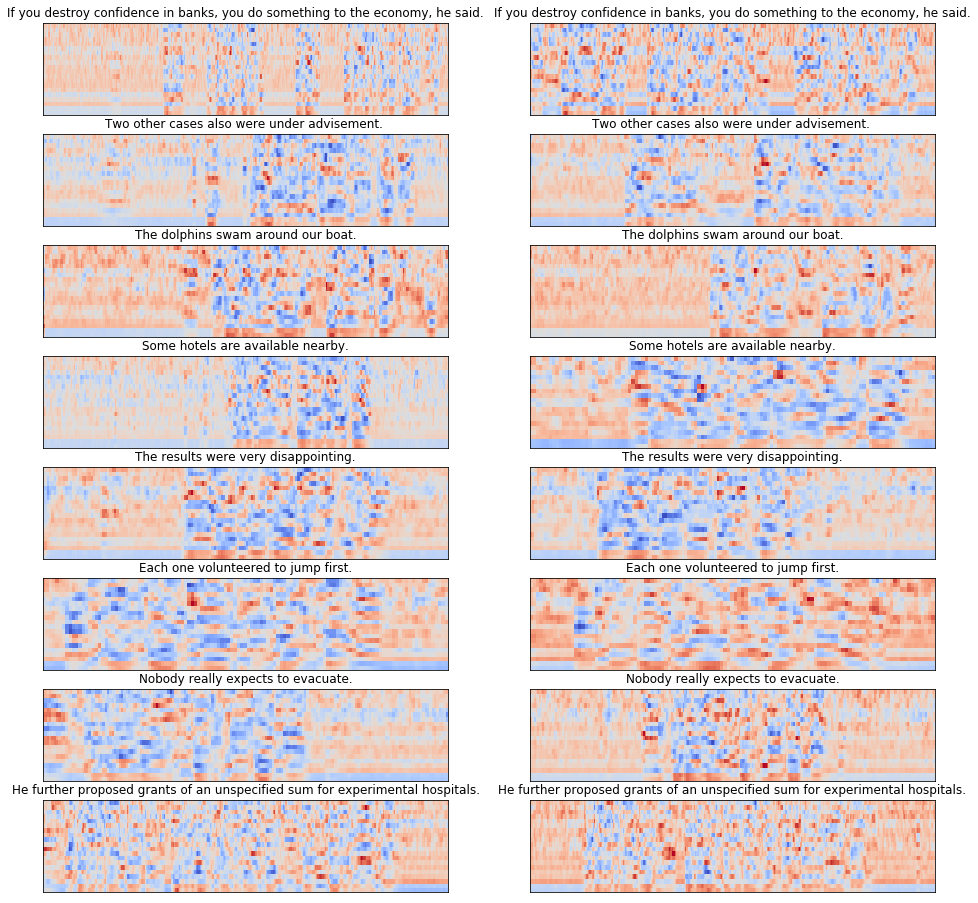

In [8]:
cat = dict(zip(prompts, prompt_text))  # Dictionary to look up prompt text from prompt code
num_examples = 16

fig = plt.figure(figsize=(16, 16))

for i in range(num_examples):
    plt.subplot(8,2,i+1)
    librosa.display.specshow(mfcc[i])
    plt.title(cat.get(prompts[i]))
    
print(cat)

The MFCC's for the first two examples ('If you destroy confidence in banks, you do something to the economy, he said') look very different. There may be pauses in the first one that we will need to correct for using DTW. Check what they sound like to make sure everything has worked OK.

In [31]:
aud_loc1 = '../data/TORGO/F03/Session2/wav_arrayMic/0006.wav'
aud_loc2 = '../data/TORGO/F03/Session2/wav_arrayMic/0007.wav'

data1, rate1 = librosa.core.load(aud_loc1)
ipd.Audio(data1, rate=rate1)

In [32]:
data2, rate2 = librosa.core.load(aud_loc2)
ipd.Audio(data2, rate=rate2)

So, there is a pause at the beginning of what we are going to use as the test file, but also there is a repetition in the training file, where the speaker actually says "If you destroy the...if you destroy confidence in banks, you do something to the economy, he said". **The repetition may cause a problem with experiments using this example.**  

Checking some of the other files, there are clear differences in the speed of articulation of the same phrase, which is exactly the problem that we are trying to overcome by using DTW.

## 3) Compare using DTW

In [11]:
from scipy.spatial.distance import euclidean
from numpy.linalg import norm
from fastdtw import fastdtw, dtw

In [12]:
x_train = [mfcc[i] for i,x in enumerate(train) if x==-1]
y_train = [prompts[i] for i,x in enumerate(train) if x==-1]
x_test = [mfcc[i] for i,x in enumerate(train) if x==1]
y_test = [prompts[i] for i,x in enumerate(train) if x==1]
print('# train: ', len(y_train))
print('# test: ', len(y_test))

# train:  15
# test:  1


In [13]:
# Calculate the DTW distance between the test example and each of the remaining
# 15 training examples. The correct match (ie minimum distance) should be versus
# the first training example

y = x_test[0]
mfcc_dist = []

for i, x in enumerate(x_train):
    distance, path = fastdtw(x.T, y.T, radius=1, dist=lambda x, y: norm(x - y))
    mfcc_dist.append(distance)

# Get the index of the matching prompt: remember that we've removed one example
# to act as the test, so we need to add one to the index of the result if we use
# it to lookup the prompt text in the original dataframe
matching_prompt = int(pd.DataFrame(mfcc_dist).idxmin())+1
print('Test prompt: {0}'.format(prompt_text[0]))
print('Best match: Number {0} = {1}'.format(matching_prompt-1, prompt_text[matching_prompt]))
pd.DataFrame(mfcc_dist)

Test prompt: If you destroy confidence in banks, you do something to the economy, he said.
Best match: Number 9 = Each one volunteered to jump first.


,0
0,3136.616078
1,3014.430779
2,3102.611789
3,2948.991182
4,2892.160640
5,2996.517768
6,3453.464165
7,3482.075285
8,3224.646049
9,2888.408671


With a radius of 1, the fastdtw algorithm incorrectly matches the test record ("If you destroy confidence in banks, you do something to the economy, he said.") with training example 9 ("Each one volunteered to jump first."). However, the radius is a parameter that controls the balance of speed and accuracy. Increasing the radius increases the accuracy but slows the calculation. The maximum accuracy is achieved when the radius equals the size of (x,y), at which point it replicates the performance of the full DTW algorithm, which unfortunately runs in O(N^2) time.

In [14]:
# Check the impact of increasing the radius

y = x_test[0]
radius = [1,5,10,15,20,30,40]
results = pd.DataFrame()

for r in radius:
    mfcc_dist = []
    for i, x in enumerate(x_train):
        distance, path = fastdtw(x.T, y.T, radius=r, dist=lambda x, y: norm(x - y))
        mfcc_dist.append(distance)
    results[r] = mfcc_dist

results

,1,5,10,15,20,30,40
0,3136.616078,3015.172617,2859.417459,2681.083044,2513.305797,2471.892285,2458.712676
1,3014.430779,2706.084496,2640.242701,2630.046593,2626.743630,2604.884716,2604.884716
2,3102.611789,2706.136086,2614.510725,2556.863169,2556.450502,2546.783881,2546.783881
3,2948.991182,2747.377501,2658.798614,2653.431454,2618.204298,2552.855517,2552.855517
4,2892.160640,2777.386770,2636.791356,2617.884620,2612.468537,2637.906551,2612.468537
5,2996.517768,2789.815654,2726.795465,2699.671370,2697.633140,2697.633140,2697.633140
6,3453.464165,3019.677054,2924.686846,2763.511403,2739.404756,2730.497936,2730.497936
7,3482.075285,2642.308238,2565.210531,2542.926204,2542.926204,2542.926204,2542.926204
8,3224.646049,2909.580711,2704.270015,2660.553583,2660.553583,2648.169771,2630.791392
9,2888.408671,2757.332830,2658.060863,2632.420594,2609.415973,2609.415973,2609.415973


**With radius > 20, the DTW algorithm correctly matches the example, despite the repetition in the training example.**

In [15]:
# Need to run more tests using other phrases to ensure this isn't a fluke

def run_dtw(test_example, radius=1):
    x_test = mfcc[test_example]
    x_train = mfcc[:test_example] + mfcc[test_example+1:]
    x_test_prompt = prompt_text[test_example]
    x_train_prompt = prompt_text[:test_example] + prompt_text[test_example+1:]
    mfcc_dist = []

    for i, x in enumerate(x_train):
        distance, path = fastdtw(x.T, x_test.T, radius=radius, dist=lambda x, y: norm(x - y))
        #distance, path = dtw(x.T, x_test.T, dist=lambda x, y: norm(x - y))
        mfcc_dist.append(distance)
        
    # Find index of the minimum value in mfcc_dist
    val, idx = min((val, idx) for (idx, val) in enumerate(mfcc_dist))
    
    return x_test_prompt, x_train_prompt[idx]

In [16]:
# Loop through the list and make sure that each one works with radius 20
for i in range(16):
    test_prompt, matching_prompt = run_dtw(i,20)
    print('Test {0}'.format(i))
    print('Test prompt: {0}'.format(test_prompt))
    print('Best Match: {0} \n'.format(matching_prompt))

Test 0
Test prompt: If you destroy confidence in banks, you do something to the economy, he said.
Best Match: If you destroy confidence in banks, you do something to the economy, he said. 

Test 1
Test prompt: If you destroy confidence in banks, you do something to the economy, he said.
Best Match: Nobody really expects to evacuate. 

Test 2
Test prompt: Two other cases also were under advisement. 
Best Match: Two other cases also were under advisement.  

Test 3
Test prompt: Two other cases also were under advisement. 
Best Match: Each one volunteered to jump first. 

Test 4
Test prompt: The dolphins swam around our boat.
Best Match: Some hotels are available nearby. 

Test 5
Test prompt: The dolphins swam around our boat.
Best Match: Each one volunteered to jump first. 

Test 6
Test prompt: Some hotels are available nearby.
Best Match: Some hotels are available nearby. 

Test 7
Test prompt: Some hotels are available nearby.
Best Match: Each one volunteered to jump first. 

Test 8
Tes

With a radius of 20, 10 out of 16 were correct (62.5%)

In [17]:
# See if the results improve with radius 30
for i in range(16):
    test_prompt, matching_prompt = run_dtw(i,30)
    print('Test {0}'.format(i))
    print('Test prompt: {0}'.format(test_prompt))
    print('Best Match: {0} \n'.format(matching_prompt))

Test 0
Test prompt: If you destroy confidence in banks, you do something to the economy, he said.
Best Match: If you destroy confidence in banks, you do something to the economy, he said. 

Test 1
Test prompt: If you destroy confidence in banks, you do something to the economy, he said.
Best Match: Nobody really expects to evacuate. 

Test 2
Test prompt: Two other cases also were under advisement. 
Best Match: Two other cases also were under advisement.  

Test 3
Test prompt: Two other cases also were under advisement. 
Best Match: Each one volunteered to jump first. 

Test 4
Test prompt: The dolphins swam around our boat.
Best Match: Some hotels are available nearby. 

Test 5
Test prompt: The dolphins swam around our boat.
Best Match: Each one volunteered to jump first. 

Test 6
Test prompt: Some hotels are available nearby.
Best Match: Some hotels are available nearby. 

Test 7
Test prompt: Some hotels are available nearby.
Best Match: Each one volunteered to jump first. 

Test 8
Tes

No improvement by increasing radius from 20 to 30 - still 10 out 16 correct (63%) 

Using higher quality head mic recordings increases accuracy to 11 out of 16 (69%)

**Next Steps**  

The results are still reasonable, especially given that we can match a single training example. It might be worth exploring the shifting technique to see whether that improves the outcome.

## Further background - Mechanics of the DTW algorithm

To calculate the DTW distance between two vectors X and Y, the first step is to create a matrix of size |Y| by |X| where the elements are the distance between every pair of points in the vectors, where distance is measured using the following methodology:

_To calculate the element [i,j] (ie the distance between the vector elements $Y_{i}$ and $X_{j}$), take the absolute value of $Y_{i}$ - $X_{j}$ and then add the minimum value of the three adjacent cells to the left, diagonal below left and below, ie cells [i-1, j], [i-1, j-1], [i, j-1]._

So, for example, if the two vectors we wish to compare are X = [1,6,2,3,0,9,4,3,6,3] and Y = [1,3,4,9,8,2,1,5,7,3] we would build the following cost matrix

![](DTW_matrix.png)

Cell [3,3] in bold with a value of 11 is calculated as |$Y_{3}$ - $X_{3}$| = |9-3| = 6, **plus** the minimum of the three adjacent cells to the left and below, ie left = 11, left diagonal below = 5, below = 5, so min{11,5,5) = 5. Along the edges where there are a limited number of adjacent cells, just add whichever cell is present, which will either be one to the left or one below (note that the diagram above incorrectly highlights cell [0,8], but the calculation provided is for the bold cell [0,4] with a value of 20)

Once the matrix is populated, it is possible to find the minimum distance between the start and ending points by selecting the cell in the top right corner, and then tracing a path back to the origin by successively choosing whichever cell in the three adjacent cells to the left and below contains the lowest value

![](DTW_path.png)

Starting with the top right cell [9,9], the cell to the left = 18, left diagonal below = 15, below = 18, so we select left diagonal below. Then the adjacent cells are left = 18, left diagonal below = 15, below = 14, so we select below. In this way, a warping path is traced back to the origin, and that path reveals which points in Y should map to points in X

![](warping_path.png)

It is common practice to apply a weighting function to the overall distance (ie the sum of the elements along the warping path) to normalize for the path length. This weighting can either be based upon the distance travelled along either the X axis, or along both X and Y.